# ct.gov Data Extractor

Pair pubmed abstracts with their `ct.gov` data

In [1]:
from cochranenlp.readers import biviewer

ct_biviewer = biviewer.ClinicalTrialsBiViewer()

### Extract Data

In [2]:
from collections import namedtuple

Targets = namedtuple('Targets', ['abstract',
                                 'pmid',
                                 'allocation',
                                 'endpoint_classification',
                                 'intervention_model',
                                 'masking',
                                 'primary_purpose',
                                 'condition',
                                 'gender',
                                 'healthy_volunteers',
                                 'maximum_age', 'minimum_age',
                                 'phase',
                                 'study_type',
                                 'primary_outcome_measure'])

def data_generator():
    for study in ct_biviewer:
        yield Targets(study.pubmed.text_all()['abstract'], study.pubmed.text_all()['pmid'], **study.clinicaltrials.fields)
        
data = list(data_generator())
df = pd.DataFrame(data, columns=Targets._fields)
df = df[df.abstract != ''] # filter away blank abstracts

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2126
Data columns (total 15 columns):
abstract                   2093 non-null object
pmid                       2093 non-null object
allocation                 1746 non-null object
endpoint_classification    1882 non-null object
intervention_model         2085 non-null object
masking                    2092 non-null object
primary_purpose            2015 non-null object
condition                  2093 non-null object
gender                     2093 non-null object
healthy_volunteers         2092 non-null object
maximum_age                2093 non-null object
minimum_age                2093 non-null object
phase                      2093 non-null object
study_type                 2093 non-null object
primary_outcome_measure    2093 non-null object
dtypes: object(15)
memory usage: 261.6+ KB


## Class Breakdowns

### Conditions

Definition: Primary disease or condition being studied, or focus of the study. Diseases or conditions should use the National Library of Medicine's Medical Subject Headings (MeSH) controlled vocabulary when possible. 

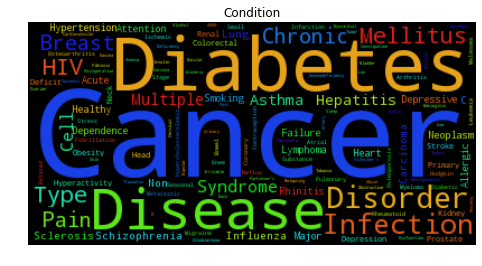

In [3]:
import wordcloud

def word_cloud(words, axes, title):
    wc = wordcloud.WordCloud().generate(words)
    axes.imshow(wc)
    axes.axis('off')
    plt.title(title)
    
fig = plt.figure(figsize=(8, 8))
axes = fig.gca()
word_cloud(' '.join(df.condition), axes, 'Condition')

### Class Balance Visualization

Minimum and maximum ages are excluded because there are so many different classes (e.g. over 17, over 18, etc.). We'd probably want to predict this value via regression instead of classification. Here is a list of the fields below, along with their ct.gov definition:

In [31]:
def pie_target(target):
    fig = plt.figure(figsize=(5, 5))
    plt.clf()
    
    axes = df.groupby(target).size().plot(kind='pie')
    axes.set_ylabel('')

#### Allocation

At least one of the following required: Intervention Model, Masking, Allocation. All may be required as part of Study Design under PL 110-85, Section 801 - participant assignment to intervention group

- N/A: single arm study
- Randomized Controlled Trial: participants are assigned to intervention groups by chance
- Nonrandomized Trial: participants are expressly assigned to intervention groups through a non-random method, such as physician choice

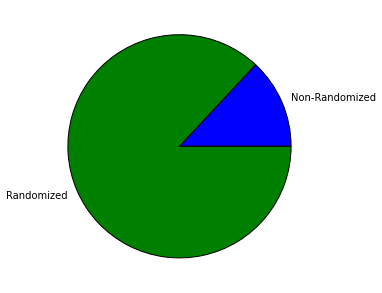

In [32]:
pie_target('allocation')

#### Endpoint Classification

Also known as **Study Classification**. Type of primary outcome or endpoint that the protocol is designed to evaluate. Select one.

- `N/A`: not applicable
- `Safety`: show if the drug is safe under conditions of proposed use
- `Efficacy`: measure of an intervention's influence on a disease or health condition
- `Safety/Efficacy`
- `Bio-equivalence`: scientific basis for comparing generic and brand name drugs
- `Bio-availability`: rate and extent to which a drug is absorbed or otherwise available to the treatment site in the body
- `Pharmacokinetics`: the action of a drug in the body over a period of time including the process of absorption, distribution and localization in tissue, biotransformation, and excretion of the compound
- `Pharmacodynamics`: action of drugs in living systems
- `Pharmacokinetics/dynamics`

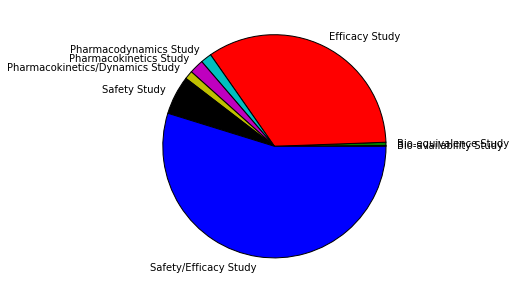

In [33]:
pie_target('endpoint_classification')

#### Intervention Model

At least one of the following required: Intervention Model, Masking, Allocation. All may be required as part of Study Design under PL 110-85, Section 801 - intervention assignments 

- `Single Group`: single arm study
- `Parallel`: participants are assigned to one of two or more groups in parallel for the duration of the study
- `Cross-over`: participants receive one of two alternative interventions during the initial phase of the study and receive the other intervention during the second phase of the study
- `Factorial`: two or more interventions, each alone and in combination, are evaluated in parallel against a control group 

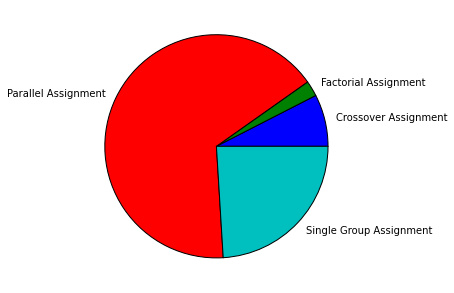

In [34]:
pie_target('intervention_model')

#### Primary Purpose

Reason for the protocol

- `Treatment`: protocol designed to evaluate one or more interventions for treating a disease, syndrome or condition
- `Prevention`: protocol designed to assess one or more interventions aimed at preventing the development of a specific disease or health condition
- `Diagnostic`: protocol designed to evaluate one or more interventions aimed at identifying a disease or health condition
- `Supportive Care`: protocol designed to evaluate one or more interventions where the primary intent is to maximize comfort, minimize side effects or mitigate against a decline in the subject's health or function. In general, supportive care interventions are not intended to cure a disease.
- `Screening`: protocol designed to assess or examine methods of identifying a condition (or risk factors for a condition) in people who are not yet known to have the condition (or risk factor).
- `Health Services Research`: protocol designed to evaluate the delivery, processes, management, organization or financing of health care.
- `Basic Science`: protocol designed to examine the basic mechanism of action (e.g., physiology, biomechanics) of an intervention.
- `Other`: describe in Detailed Description.

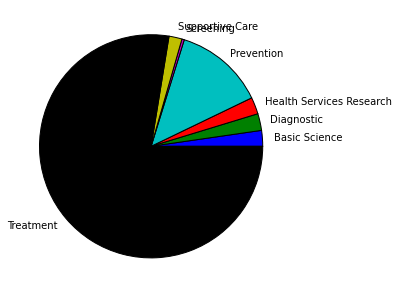

In [35]:
pie_target('primary_purpose')

#### Masking

At least one of the following required: Intervention Model, Masking, Allocation. All may be required as part of Study Design under PL 110-85, Section 801 - knowledge of intervention assignments

- `Open`: no masking is used. All involved know the identity of the intervention assignment.
- `Single Blind`: one party, either the investigator or participant, is unaware of the intervention assignment; also called single-masked study.
- `Double Blind`: two or more parties are unaware of the intervention assignment

If Single Blind or Double Blind is selected, check the role(s) that are to be masked: Subject, Caregiver, Investigator or Outcomes Assessor.

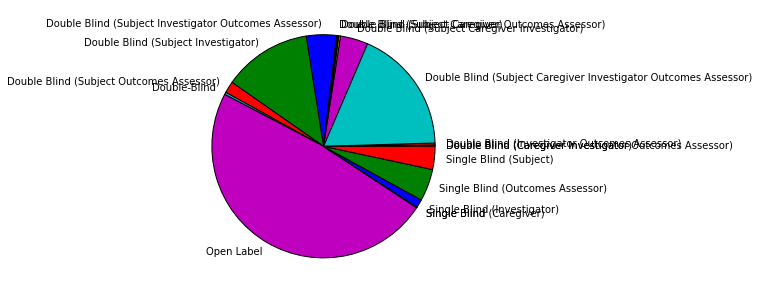

In [36]:
pie_target('masking')

#### Gender

Definition: Physical gender of individuals who may participate in the protocol. Select one.

- `Both`: both female and male participants are being studied
- `Female`: only female participants are being studied
- `Male`: only male participants are being studied 

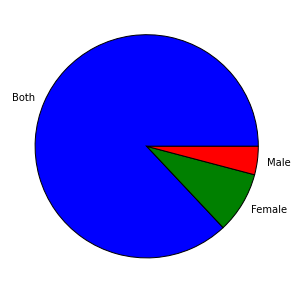

In [39]:
pie_target('gender')

#### Accepts Healthy Volunteers?

Definition: Indicate if persons who have not had the condition(s) being studied or otherwise related conditions or symptoms, as specified in the eligibility requirements, may participate in the study.

- `Accepts Healthy Volunteers`
- `No`

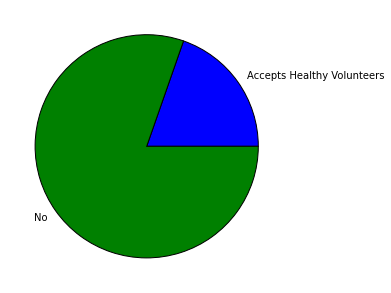

In [43]:
pie_target('healthy_volunteers')

#### Maximum Age

Definition: Maximum age of participants.
    
Provide a number and a unit of time (years, months, weeks, days, hours or minutes). Select "N/A (No limit)" if no maximum age is indicated.

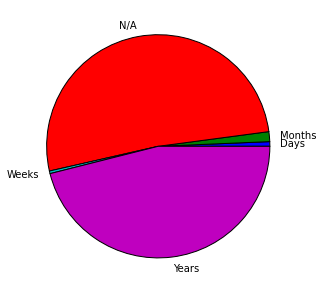

In [204]:
df['max_age'] = np.nan

for time_chunk in ('Days', 'Weeks', 'Months', 'Years', 'N/A'):
    df.ix[df.maximum_age.apply(lambda s: time_chunk in s), 'max_age'] = time_chunk

pie_target('max_age')

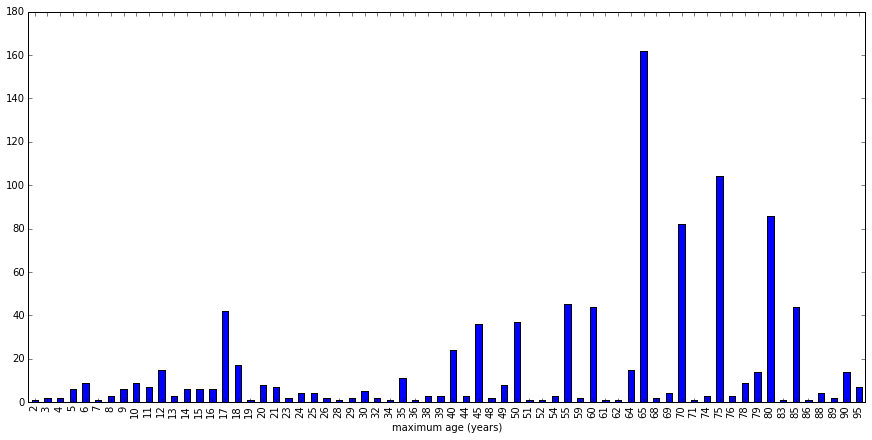

In [184]:
fig = plt.figure(figsize=(15, 7))
plt.clf()

ages = df[df.maximum_age.apply(lambda s: 'Years' in s)].groupby('maximum_age').size() # get only maximum age entries which correspond to the time chunk we're interested in
ages.index = ages.reset_index().maximum_age.apply(lambda s: int(s.split()[0])) # trim off string text and convert to int

axes = ages.sort_index().plot(kind='bar')
axes.set_xlabel('maximum age ({})'.format('Years'.lower()))

#### Minimum Age

Definition: Minimum age of participants. Provide a number and select a unit of time (years, months, weeks, days, hours or minutes). Select "N/A (No limit)" if no minimum age is indicated.

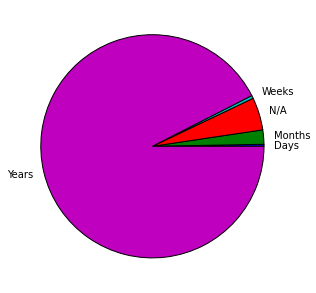

In [205]:
df['min_age'] = np.nan

for time_chunk in ('Days', 'Weeks', 'Months', 'Years', 'N/A'): # missing Year here!
    df.ix[df.minimum_age.apply(lambda s: time_chunk in s), 'min_age'] = time_chunk

pie_target('min_age')

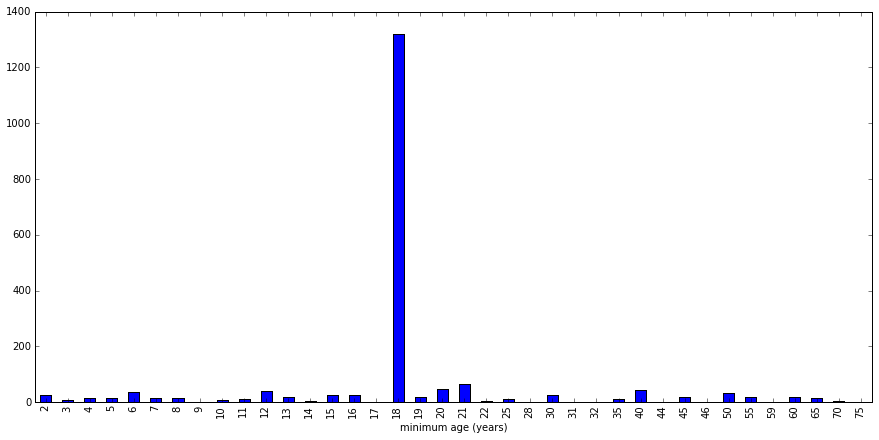

In [199]:
fig = plt.figure(figsize=(15, 7))
plt.clf()

ages = df[df.minimum_age.apply(lambda s: 'Years' in s)].groupby('minimum_age').size() # get only minimum age entries which correspond to the time chunk we're interested in
ages.index = ages.reset_index().minimum_age.apply(lambda s: int(s.split()[0])) # trim off string text and convert to int

axes = ages.sort_index().plot(kind='bar')
axes.set_xlabel('minimum age ({})'.format('Years'.lower()))

In [195]:
min_age.minimum_age.apply(lambda s: s.split()[1]).unique()

array(['Years', 'Months', 'Weeks', 'Year', 'Month', 'Days'], dtype=object)

#### Study Phase

Definition: Phase of investigation, as defined by the US FDA for trials involving investigational new drugs. Use "N/A" for trials that do not involve drug or biologic products. Select only one.

- `N/A`: for trials without phases (e.g., trials of devices or behavioral interventions)
- `Phase 0`: exploratory trials, involving very limited human exposure, with no therapeutic or diagnostic intent (e.g., screening studies, microdose studies). See FDA guidance on exploratory IND studies for more information.
- `Phase 1`: includes initial studies to determine the metabolism and pharmacologic actions of drugs in humans, the side effects associated with increasing doses, and to gain early evidence of effectiveness; may include healthy participants and/or patients
- `Phase 1/Phase 2`: for trials that are a combination of phases 1 and 2
- `Phase 2`: includes controlled clinical studies conducted to evaluate the effectiveness of the drug for a particular indication or indications in patients with the disease or condition under study and to determine the common short-term side effects and risks
- `Phase 2/Phase 3`: for trials that are a combination of phases 2 and 3
- `Phase 3`: includes expanded controlled and uncontrolled trials after preliminary evidence suggesting effectiveness of the drug has been obtained, and are intended to gather additional information to evaluate the overall benefit-risk relationship of the drug and provide an adequate basis for physician labeling
- `Phase 4`: studies of FDA-approved drugs to delineate additional information including the drug's risks, benefits, and optimal use

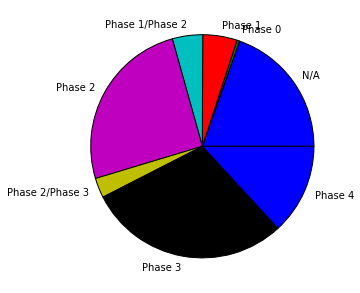

In [200]:
pie_target('phase')

#### Study Type

Definition: Nature of the investigation. Select one.

- `Interventional`: studies in human beings in which individuals are assigned by an investigator based on a protocol to receive specific interventions. Subjects may receive diagnostic, therapeutic or other types of interventions. The assignment of the intervention may or may not be random. The individuals are then followed and biomedical and/or health outcomes are assessed.

- `Observational`: studies in human beings in which biomedical and/or health outcomes are assessed in pre-defined groups of individuals. Subjects in the study may receive diagnostic, therapeutic, or other interventions, but the investigator does not assign specific interventions to the subjects of the study.

    - Patient Registry: For observational studies only, check the Patient Registry box if this record describes a study that is also considered to be a Patient Registry. This type of study should only be registered once in the PRS, by the sponsor responsible for the primary data collection and analysis.
    
        The Agency for Healthcare Research and Quality (AHRQ) defines a Patient Registry as including an organized system that uses observational methods to collect uniform data (clinical and other) prospectively for a population defined by a particular disorder/disease, condition (including susceptibility to a disorder), or exposure (including products, health care services, and/or procedures) and that serves a predetermined scientific, clinical, or policy purpose. Patient registries may be single purpose or on-going data collection programs that address one or more questions.


- `Expanded Access`: records describing the procedure for obtaining an experimental drug or device for patients who are not adequately treated by existing therapy, who do not meet the eligibility criteria for enrollment, or who are otherwise unable to participate in a controlled clinical study. Expanded Access records are used to register all types of non-protocol access to experimental treatments, including protocol exception, single-patient IND, treatment IND, compassionate use, emergency use, continued access and parallel track.

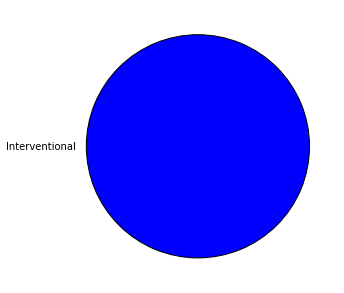

In [202]:
pie_target('study_type')

### Store

In [5]:
abstracts_targets = df

%store abstracts_targets

Stored 'abstracts_targets' (DataFrame)
